### Novelty/OOD Detection

Whilst relative chebyshev distance can give some ideas about potentially out of distribution counterfactual explanations, we look to implementing novelty detection algorithms for this purpose. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from scipy.optimize import minimize
from scipy.spatial.distance import cdist, pdist
from scipy import stats
from sklearn.neighbors import DistanceMetric
from tslearn.datasets import UCR_UEA_datasets
from tslearn.neighbors import NearestNeighbors, KNeighborsTimeSeries
from sklearn.metrics import accuracy_score
from scipy.interpolate import interp1d
import tensorflow as tf
from sklearn import preprocessing
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Conv1D, GlobalAveragePooling1D, BatchNormalization, Conv2D
from tensorflow.keras.layers import GlobalAveragePooling1D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.backend import function
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest

from tslearn.utils import to_sklearn_dataset
from tensorflow import keras
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
print(tf.__version__)


2.4.1


In [2]:
dataset = 'CBF'

In [3]:
def ucr_data_loader(dataset):
    
    X_train, y_train, X_test, y_test = UCR_UEA_datasets().load_dataset(dataset)
    
    return X_train, y_train, X_test, y_test

In [4]:
def label_encoder(training_labels, testing_labels):
    
    le = preprocessing.LabelEncoder()
    le.fit(np.concatenate((training_labels, testing_labels), axis=0))
    y_train = le.transform(training_labels)
    y_test = le.transform(testing_labels)
    
    return y_train, y_test
    
    

In [5]:
X_train, y_train, X_test, y_test = ucr_data_loader(str(dataset))
y_train, y_test = label_encoder(y_train, y_test)

### Novelty Detection Raw Time Series

Using the Local Outlier Factor Method, OC-SVM and Isolation Forest to detect potentially out-of-distribution counterfactuals

In [6]:
OOD_lof_cam_swap = []
OOD_svm_cam_swap = []

OOD_lof_min_edit = []
OOD_svm_min_edit = []

for dataset in ['CBF', 'chinatown', 'coffee', 'ecg200', 'gunpoint']:

    X_train, y_train, X_test, y_test = ucr_data_loader(str(dataset))
    y_train, y_test = label_encoder(y_train, y_test)
    
    min_edit_cf = np.load('../W-CF/'+str(dataset)+'_wachter_cf.npy')
    cam_swap_cf = np.load('../Native-Guide/'+str(dataset)+'_native_guide_isw.npy')

    lof = LocalOutlierFactor(n_neighbors=int(np.sqrt(len(X_train))),novelty=True, metric='euclidean')
    lof.fit(to_sklearn_dataset(X_train))
    
    novelty_detection_min_edit = lof.predict(to_sklearn_dataset((min_edit_cf)))
    novelty_detection_cam_swap = lof.predict(to_sklearn_dataset((cam_swap_cf)))
    
    ood_min_edit = np.count_nonzero(novelty_detection_min_edit == -1)
    ood_cam_swap = np.count_nonzero(novelty_detection_cam_swap == -1)

    OOD_lof_min_edit.append((ood_min_edit/len(min_edit_cf)))
    OOD_lof_cam_swap.append((ood_cam_swap/len(cam_swap_cf)))

    
    #OCSVM
    clf = OneClassSVM(gamma='scale', nu=0.02).fit(to_sklearn_dataset(X_train))
    
    novelty_detection_min_edit = clf.predict(to_sklearn_dataset((min_edit_cf)))
    novelty_detection_cam_swap = clf.predict(to_sklearn_dataset((cam_swap_cf)))
    
    ood_min_edit = np.count_nonzero(novelty_detection_min_edit == -1)
    ood_cam_swap = np.count_nonzero(novelty_detection_cam_swap == -1)

    OOD_svm_min_edit.append((ood_min_edit/len(min_edit_cf)))
    OOD_svm_cam_swap.append((ood_cam_swap/len(cam_swap_cf)))

In [7]:
np.around(OOD_lof_min_edit,decimals=2), np.around(OOD_lof_cam_swap, decimals=2)

(array([0.09, 0.11, 0.04, 0.22, 0.19]), array([0.  , 0.  , 0.04, 0.02, 0.23]))

In [8]:
np.around(OOD_svm_min_edit, decimals=2), np.around(OOD_svm_cam_swap, decimals=2)

(array([0.69, 0.44, 0.25, 0.5 , 0.18]), array([0.5 , 0.07, 0.14, 0.16, 0.11]))

#### Isolation forest

Isolation Forest has certain degree of randomness. To mitigate the effects of this we average results over 10 seeds. 

In [9]:
OOD_if_cam_swap = []
OOD_if_min_edit = []

for dataset in ['CBF', 'chinatown', 'coffee', 'ecg200', 'gunpoint']:

    X_train, y_train, X_test, y_test = ucr_data_loader(str(dataset))
    y_train, y_test = label_encoder(y_train, y_test)
    
    min_edit_cf = np.load('../W-CF/'+str(dataset)+'_wachter_cf.npy')
    cam_swap_cf = np.load('../Native-Guide/'+str(dataset)+'_native_guide_isw.npy')
    
    
    for seed in range(0,10):
        iforest = IsolationForest(random_state=seed).fit(to_sklearn_dataset(X_train))

        novelty_detection_min_edit = iforest.predict(to_sklearn_dataset((min_edit_cf)))
        novelty_detection_cam_swap = iforest.predict(to_sklearn_dataset((cam_swap_cf)))

        ood_min_edit = np.count_nonzero(novelty_detection_min_edit == -1)
        ood_cam_swap = np.count_nonzero(novelty_detection_cam_swap == -1)

        OOD_if_min_edit.append((ood_min_edit/len(min_edit_cf)))
        OOD_if_cam_swap.append((ood_cam_swap/len(cam_swap_cf)))

In [10]:
print(np.mean(OOD_if_min_edit[0:10]), np.mean(OOD_if_cam_swap[0:10]))
print(np.mean(OOD_if_min_edit[10:20]), np.mean(OOD_if_cam_swap[10:20]))
print(np.mean(OOD_if_min_edit[20:30]), np.mean(OOD_if_cam_swap[20:30]))
print(np.mean(OOD_if_min_edit[30:40]), np.mean(OOD_if_cam_swap[30:40]))
print(np.mean(OOD_if_min_edit[40:50]), np.mean(OOD_if_cam_swap[40:50]))

0.14922222222222223 0.08744444444444444
0.4836734693877551 0.36938775510204086
0.41428571428571426 0.36785714285714277
0.28200000000000003 0.259
0.22733333333333333 0.202


### Novelty Detection on Matrix Profile Representation

In [11]:
from tslearn.matrix_profile import MatrixProfile
import matplotlib.transforms as mtransforms

In [12]:
def mp_representation(data):
    matrix_profile_representation = []
    for instance in range(len(data)):
        s_x = data[instance]
        mp = MatrixProfile(subsequence_length=10, scale=False)
        mp_series = mp.fit_transform([s_x])[0]
        matrix_profile_representation.append(mp_series)
    return np.array(matrix_profile_representation)

In [13]:
mp_representation(X_train)
mp_representation(min_edit_cf).shape

(150, 141, 1)

In [14]:
OOD_lof_cam_swap = []
OOD_svm_cam_swap = []

OOD_lof_min_edit = []
OOD_svm_min_edit = []

for dataset in ['CBF','chinatown', 'coffee', 'ecg200', 'gunpoint']:
#for dataset in ['ecg200']:

    X_train, y_train, X_test, y_test = ucr_data_loader(str(dataset))
    y_train, y_test = label_encoder(y_train, y_test)
    
    X_train = mp_representation(X_train)
    
    min_edit_cf = np.load('../W-CF/'+str(dataset)+'_wachter_cf.npy')
    min_edit_cf = mp_representation(min_edit_cf)
    cam_swap_cf = np.load('../Native-Guide/'+str(dataset)+'_native_guide_isw.npy')
    cam_swap_cf = mp_representation(cam_swap_cf)

    lof = LocalOutlierFactor(n_neighbors=int(np.sqrt(len(X_train))),novelty=True, metric='euclidean')
    lof.fit(to_sklearn_dataset(X_train))
    
    novelty_detection_min_edit = lof.predict(to_sklearn_dataset((min_edit_cf)))
    novelty_detection_cam_swap = lof.predict(to_sklearn_dataset((cam_swap_cf)))
    
    ood_min_edit = np.count_nonzero(novelty_detection_min_edit == -1)
    ood_cam_swap = np.count_nonzero(novelty_detection_cam_swap == -1)

    OOD_lof_min_edit.append((ood_min_edit/len(min_edit_cf)))
    OOD_lof_cam_swap.append((ood_cam_swap/len(cam_swap_cf)))

    
    #OCSVM
    clf = OneClassSVM(gamma='scale', nu=0.02).fit(to_sklearn_dataset(X_train))
    
    novelty_detection_min_edit = clf.predict(to_sklearn_dataset((min_edit_cf)))
    novelty_detection_cam_swap = clf.predict(to_sklearn_dataset((cam_swap_cf)))
    
    ood_min_edit = np.count_nonzero(novelty_detection_min_edit == -1)
    ood_cam_swap = np.count_nonzero(novelty_detection_cam_swap == -1)

    OOD_svm_min_edit.append((ood_min_edit/len(min_edit_cf)))
    OOD_svm_cam_swap.append((ood_cam_swap/len(cam_swap_cf)))

In [15]:
#OOD_lof_min_edit, OOD_lof_cam_swap
OOD_svm_min_edit, OOD_svm_cam_swap

([0.6111111111111112,
  0.8746355685131195,
  0.42857142857142855,
  0.44,
  0.5666666666666667],
 [0.3388888888888889, 0.22448979591836735, 0.21428571428571427, 0.13, 0.3])

### OOD Plots 

In [16]:
X_train, y_train, X_test, y_test = ucr_data_loader(str('ecg200'))
y_train, y_test = label_encoder(y_train, y_test)

min_edit_cf = np.load('../W-CF/'+str('ecg200')+'_wachter_cf.npy')

Text(2, 6.2, 'B.')

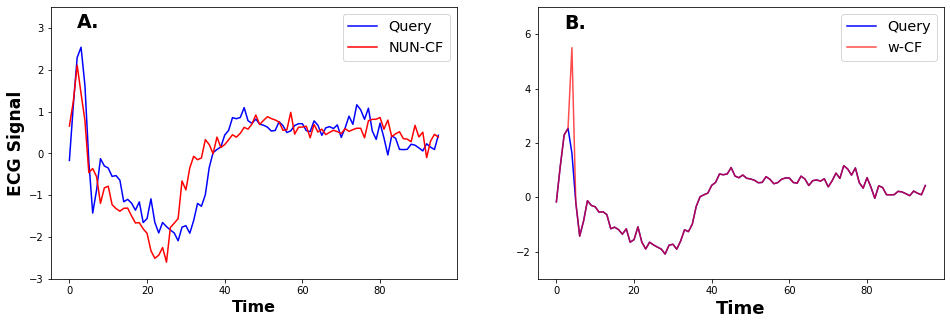

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

ax1.plot(X_test[22], color='blue', label = 'Query')
ax1.plot(X_train[44], color='red', label = 'NUN-CF')
ax1.legend(loc='upper right', prop={'size': 'x-large'})  
ax1.set_xlabel('Time', rotation=0, size=16, fontweight='bold')
ax1.set_ylabel('ECG Signal', size='xx-large', fontweight='bold')
ax1.set_ylim(-3,3.5)


ax2.plot(X_test[22], color='blue', label = 'Query')
ax2.plot(min_edit_cf[22], color='red', alpha = 0.7, label = 'w-CF')
ax2.legend(loc='upper right', prop={'size': 'x-large'})
ax2.set_xlabel('Time', rotation=0, size=18, fontweight='bold')
ax2.set_ylim(-3,7)


ax1.text(2,3,'A.', fontsize=19, fontweight='bold')
ax2.text(2,6.2,'B.', fontsize=19, fontweight='bold')

#plt.savefig('../Images/OOD_comparison.pdf')